In [3]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from msmbuilder.featurizer import DihedralFeaturizer
import pyemma
fnames = glob('src_snapshot/*.h5')

traj = md.load_frame(fnames[0],0)
top = traj.topology
atoms = [a for a in top.atoms]

residues_of_interest = [328,
                        317,
                        408,
                        387,
                        447,
                        339,
                        341,
                        326,
                        284,
                        296,
                        396,
                        395,
                        397,
                        349,
                        454,
                        458
                       ]

def from_residues_to_atoms(residues_of_interest):
    atoms_of_interest = []

    for residue in residues_of_interest:
        atom_inds_in_residue = [i for i in range(len(atoms)) if str(residue) in str(atoms[i])]
        atoms_of_interest.append(atom_inds_in_residue)

    atoms_of_interest = np.hstack(atoms_of_interest)
    return atoms_of_interest

def create_feature_bitmask(indices,atoms_of_interest):
    '''
    indices is an array-like of array-likes
    
    atoms_of_interest is an array
    '''
    
    bitmask = np.zeros(len(indices),dtype=bool)
    
    for i in range(len(indices)):
        okay = False
        for ind in indices[i]:
            if ind in atoms_of_interest:
                okay = True
        if okay:
            bitmask[i] = 1
    return bitmask


def compute_dihedrals(traj,types=['phi', 'psi', 'omega', 'chi1', 'chi2', 'chi3', 'chi4']):
    # associate string arguments with the appropriate mdtraj functions
    type_dict = {'phi':md.compute_phi,
                 'psi':md.compute_psi,
                 'omega':md.compute_omega,
                 'chi1':md.compute_chi1,
                 'chi2':md.compute_chi2,
                 'chi3':md.compute_chi3,
                 'chi4':md.compute_chi4,
                }
    X = []
    all_indices = []
    
    # compute all dihedral angles
    for t in types:
        indices,angles = type_dict[t](traj)
        
        X.append(angles)
        all_indices.append(indices)
    
    # concatenate and return
    return np.vstack(all_indices),np.hstack(X)
    
def residue_filtered_dihedrals(traj,residues_of_interest,
                               types=['phi', 'psi', 'omega', 'chi1', 'chi2', 'chi3', 'chi4'],
                               ):
    
    # associate string arguments with the appropriate mdtraj functions
    type_dict = {'phi':md.compute_phi,
                 'psi':md.compute_psi,
                 'omega':md.compute_omega,
                 'chi1':md.compute_chi1,
                 'chi2':md.compute_chi2,
                 'chi3':md.compute_chi3,
                 'chi4':md.compute_chi4,
                }
    
    # convert residues_of_interest into atoms_of_interest
    atoms_of_interest = from_residues_to_atoms(residues_of_interest)
    
    # compute all dihedral angles, and keep only those that involve the atoms of interest
    X = []
    all_indices = []
    for t in types:
        indices,angles = type_dict[t](traj)
        bitmask = create_feature_bitmask(indices,atoms_of_interest)
        filtered_angles = angles[:,bitmask]
        filtered_indices = indices[bitmask]
        
        X.append(filtered_angles)
        all_indices.append(filtered_indices)
    
    # concatenate and return
    return np.vstack(all_indices),np.hstack(X)

def create_overlap_matrix(dtrajs):
    overlap_matrix = np.zeros((len(dtrajs),len(dtrajs)))

    sets = [set(traj) for traj in dtrajs]

    for i in range(len(overlap_matrix)):
        for j in range(len(overlap_matrix)):
            overlap_matrix[i,j] = len(sets[i].intersection(sets[j]))
    
    return overlap_matrix

def find_run_boundaries(fnames):
    runs = []
    for fname in fnames:
        i = fname.find('run')
        j = fname.find('-')
        runs.append(int(fname[i+3:j]))
    
    ticks = []
    for i in range(1,len(runs)):
        if runs[i] != runs[i-1]:
            ticks.append(i-1)
    return ticks

def plot_binary_overlap_matrix(overlap_matrix,name='Abl'):
    plt.imshow(overlap_matrix>0,interpolation='none',cmap='Blues');
    #plt.colorbar()
    plt.xlabel('Clones (grouped by run)')
    plt.ylabel('Clones (grouped by run)')
    plt.title(name+': Presence/absence of discrete state overlap among clones')
    ticks = find_run_boundaries(fnames)
    labels = ['']*len(ticks)
    plt.xticks(ticks,labels)
    plt.yticks(ticks,labels)
    plt.grid(linestyle='-',color='grey',alpha=0.1)

In [3]:
# compute features
X = []
for fname in fnames:
    indices,x = compute_dihedrals(md.load(fname),types=['phi','psi'])
    X.append(x)

In [4]:
# expand by sin and cos
X_ = [np.hstack([np.sin(x),np.cos(x)]) for x in X]
indices_ = np.vstack((indices,indices))

In [4]:
from msmbuilder.featurizer import DihedralFeaturizer
dih_model = DihedralFeaturizer()

X_ = []
for fname in fnames:
    x = dih_model.fit_transform([md.load(fname)])[0]
    X_.append(x)

In [5]:
# find slowest-decorrelating linear combination of features
tica = pyemma.coordinates.tica(X_,lag=100,dim=50)

# find individual features that best summarize these tICs
tic_inds = np.argmax(np.abs(tica.feature_TIC_correlation),0)

# use those individual features as axes instead
Y_ = [np.vstack([x[:,i] for i in tic_inds]).T for x in X_]

calculate covariances: 100% (142/142) [############################] eta 00:00 |

In [12]:
# full transform
Y = tica.get_output()

getting output of TICA: 100% (142/142) [###########################] eta 00:01 -

In [23]:
Y_star = [y[:,:50] for y in Y]

In [22]:
# now examine only the top-k of these
k = 25
Y_truncated = [y_[:,:k] for y_ in Y_]

In [7]:
# which ones?
atoms_included = indices_[tic_inds[:k]]

# to-do: convert to residues


In [ ]:
np.save

In [10]:
# ndgrid discretization
from msmbuilder.cluster import NDGrid
ndgrid = NDGrid(n_bins_per_feature=3)
dtrajs = ndgrid.fit_transform(Y_truncated)

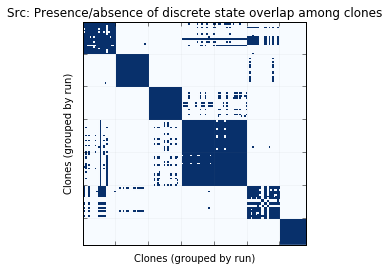

In [11]:
overlap_matrix = create_overlap_matrix(dtrajs)
plot_binary_overlap_matrix(overlap_matrix,'Src')

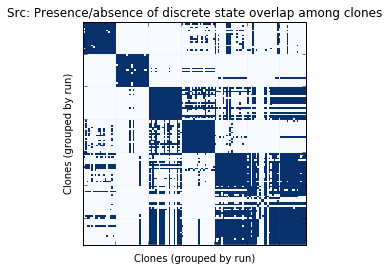

In [19]:
ndgrid = NDGrid(n_bins_per_feature=2)
dtrajs = ndgrid.fit_transform(Y_star)
overlap_matrix = create_overlap_matrix(dtrajs)
plot_binary_overlap_matrix(overlap_matrix,'Src')

In [24]:
kmeans = pyemma.coordinates.cluster_mini_batch_kmeans(Y_star,1000,max_iter=200)
dtrajs = kmeans.get_output()
dtrajs = [traj[:,0] for traj in dtrajs]

kmeans iterations:  28% ( 56/200) [########                        ] eta 17:04 -03-03-16 12:52:14 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[2] INFO     Cluster centers converged after 57 steps.
getting output of MiniBatchKmeansClustering: 100% (142/142) [######] eta 00:00 \

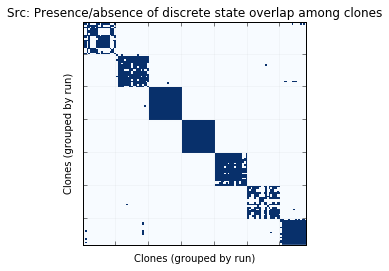

In [25]:
overlap_matrix = create_overlap_matrix(dtrajs)
plot_binary_overlap_matrix(overlap_matrix,'Src')

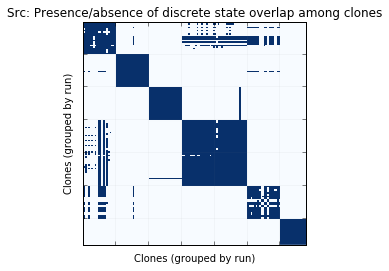

In [9]:
overlap_matrix = create_overlap_matrix(dtrajs)
plot_binary_overlap_matrix(overlap_matrix,'Src')

In [130]:
# now, I want to automate the search for the minimal feature set that results in a broken matrix

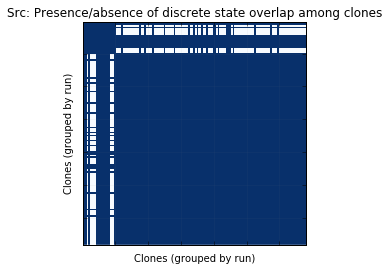

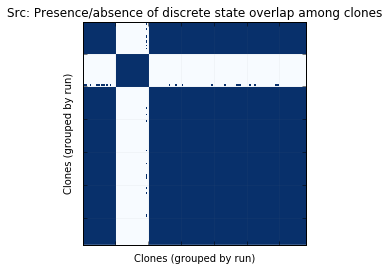

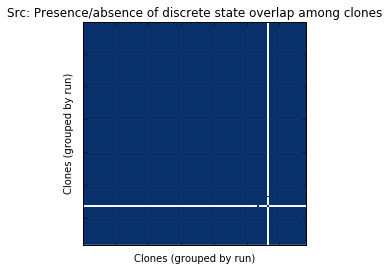

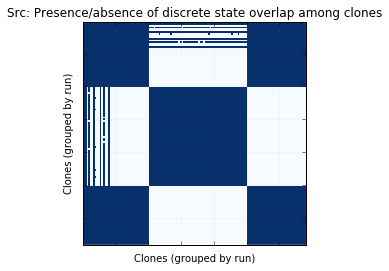

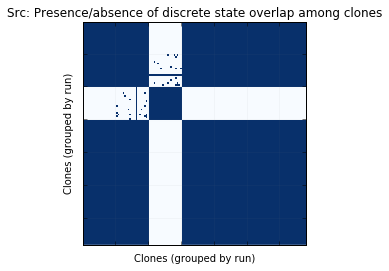

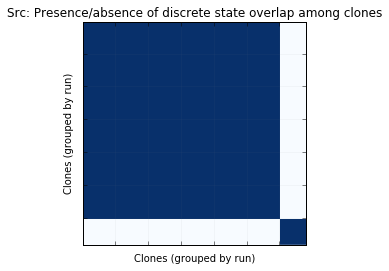

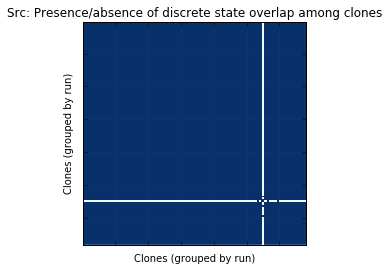

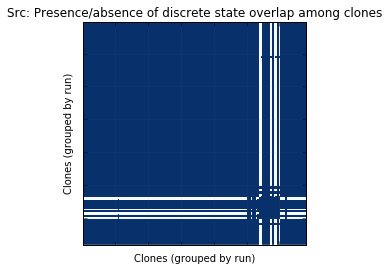

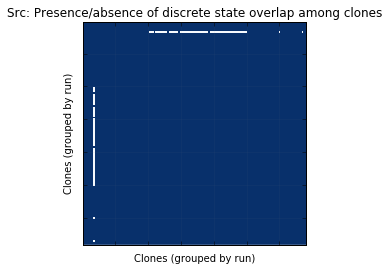

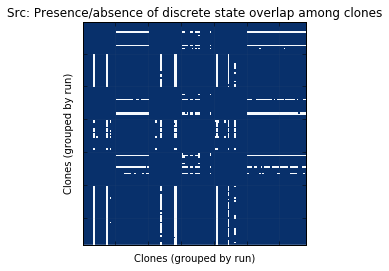

In [16]:
# first, sweep over individual parameters
for i in range(k):
    Y__ = [x[:,i].reshape((len(x),1)) for x in Y_truncated]
    ndgrid = NDGrid(n_bins_per_feature=1000)
    dtrajs = ndgrid.fit_transform(Y__)
    overlap_matrix = create_overlap_matrix(dtrajs)
    if np.sum(overlap_matrix==0)>0:
        plt.figure()
        plot_binary_overlap_matrix(overlap_matrix,'Src')

In [27]:
# so, there isn't a single dihedral in those 25 that explains everything
# what about if we search over all dihedrals?

# first, sweep over individual parameters
for i in range(len(indices))[:10]:
    Y__ = [x[:,i].reshape((len(x),1)) for x in X_]
    ndgrid = NDGrid(n_bins_per_feature=10)
    dtrajs = ndgrid.fit_transform(Y__)
    overlap_matrix = create_overlap_matrix(dtrajs)
    if np.sum(overlap_matrix==0)>0:
        plt.figure()
        plot_binary_overlap_matrix(overlap_matrix,'Src')

NameError: name 'indices' is not defined

In [30]:
top.atom(100)

LYS275-HB2